In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA

In [2]:
# configure df options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:,.5f}'.format

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Read samples from one station

In [4]:
station_code = 'SONDOC'

#### Read true raw samples

In [5]:
df = pd.read_csv('../../dataset/final/bentre-cleaned.csv', parse_dates=['date'])

In [6]:
df.set_index('date', inplace=True)

In [7]:
df = df[df['code'] == station_code]

In [8]:
# How samples distributed
df.groupby(df.index.year).count()

,code,min,max,x,y,cm
date,,,,,,
2002,181,181,181,181,181,181
2003,181,181,181,181,181,181
2004,182,182,182,182,182,182
2005,181,181,181,181,181,181
2006,181,181,181,181,181,181
2007,181,181,181,181,181,181
2008,182,182,182,182,182,182
2009,181,181,181,181,181,181
2010,181,181,181,181,181,181


##### From 2002 to 2010, samples are completed for dry seasons: 181 for normal years; 182 for leap years (January to June)
#### 2011 and 2018 have samples from January to May (151 days)
#### 2012 to 2016 have less samples, missing dates
#### 2017 has no samples at all

#### Reread prepared samples

In [9]:
df = pd.read_csv(f'../../dataset/final/stations/{station_code}.csv', parse_dates=['date'])

In [10]:
# set index to time-series based 'date'
df.set_index('date', inplace=True)

In [11]:
df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=6209, freq=None)

In [12]:
# can not set index frequency to D - daily due to missing discontinuous timestamps in the dataset
df.index.freq = 'D'
df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=6209, freq='D')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6209 entries, 2002-01-01 to 2018-12-31
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   code    6209 non-null   object 
 1   min     6209 non-null   float64
 2   max     6209 non-null   float64
dtypes: float64(2), object(1)
memory usage: 194.0+ KB


In [14]:
# sort by date index
df.sort_index(inplace=True)

df.head()

,code,min,max
date,,,
2002-01-01,SONDOC,0.10000,0.30000
2002-01-02,SONDOC,0.10000,0.40000
2002-01-03,SONDOC,0.20000,0.40000
2002-01-04,SONDOC,0.20000,0.50000
2002-01-05,SONDOC,0.10000,0.60000


### ARIMA Self Help

In [15]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |

### Split training and test sets  
Use 2002 to 2015 samples for training, 2016 test while using 2018 for evaluation

In [16]:
test_year = 2016

In [17]:
train_df = df[df.index.year < test_year]
train_df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name='date', length=5113, freq='D')

In [18]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
min,"5,113.00000",1.09981,1.99923,0.01000,0.01000,0.01000,1.50000,12.90000
max,"5,113.00000",2.84172,4.17534,0.01000,0.01000,0.01000,5.20000,25.50000


In [19]:
test_df = df[df.index.year == test_year]
test_df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=366, freq='D')

In [20]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
min,366.00000,3.43527,4.68575,0.01000,0.01000,0.01000,6.10000,14.90000
max,366.00000,6.44730,7.84975,0.01000,0.01000,0.01000,12.58750,27.40000


In [21]:
# January 1 to May 31 without Feb 29
def compact_to_dry_season(data):
    # drop Feb 29
    drop_index = data[(data.index.month == 2) & (data.index.day == 29)].index
    data = data.drop(drop_index)
    
    # drop all dates after May 31
    drop_index = data[data.index.month >= 6].index
    data = data.drop(drop_index)
    
    # convert to RangeIndex
    return data.reset_index()

In [50]:
# Using index instead of time series
train_df = compact_to_dry_season(train_df)

In [51]:
train_df.head()

,date,code,min,max
0,2002-01-01,SONDOC,0.10000,0.30000
1,2002-01-02,SONDOC,0.10000,0.40000
2,2002-01-03,SONDOC,0.20000,0.40000
3,2002-01-04,SONDOC,0.20000,0.50000
4,2002-01-05,SONDOC,0.10000,0.60000


In [56]:
train_df.tail()

,date,code,min,max
2109,2015-05-27,SONDOC,1.00000,6.40000
2110,2015-05-28,SONDOC,1.60000,6.50000
2111,2015-05-29,SONDOC,3.10000,6.00000
2112,2015-05-30,SONDOC,0.01000,0.01000
2113,2015-05-31,SONDOC,0.01000,0.01000


In [53]:
# Using index instead of time series
test_df = compact_to_dry_season(test_df)

In [54]:
# Using index instead of time series: move test_df index after train_df index
test_df.index += len(train_df)

In [55]:
test_df.head()

,date,code,min,max
2114,2016-01-01,SONDOC,0.01000,0.01000
2115,2016-01-02,SONDOC,2.70000,6.90000
2116,2016-01-03,SONDOC,3.70000,6.70000
2117,2016-01-04,SONDOC,5.30000,7.10000
2118,2016-01-05,SONDOC,5.60000,8.16000


In [57]:
test_df.tail()

,date,code,min,max
2260,2016-05-27,SONDOC,1.30000,6.26667
2261,2016-05-28,SONDOC,1.00000,6.63333
2262,2016-05-29,SONDOC,0.70000,7.00000
2263,2016-05-30,SONDOC,0.90000,7.50000
2264,2016-05-31,SONDOC,1.10000,7.60000


### Try out some simpler models

In [29]:
value_field = 'max'

# seasonal adjustment
adjustment = 'additive'
#adjustment = 'multiplicative'

In [30]:
# Annual
season_length = test_df.shape[0]  # same length of test data if using time series

season_length

366

1. Holt-Winters method via Exponential Smoothing

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(train_df[value_field], 
                                trend=adjustment, seasonal=adjustment, 
                                seasonal_periods=season_length).fit()

In [32]:
hw_prediction = hw_model.forecast(season_length)

In [33]:
hw_prediction.head(10)

2016-01-01   -0.00190
2016-01-02   -0.01985
2016-01-03   -0.01759
2016-01-04   -0.03173
2016-01-05    0.00083
2016-01-06    0.00927
2016-01-07    0.05748
2016-01-08    0.07676
2016-01-09    0.12192
2016-01-10    0.19122
Freq: D, dtype: float64

In [34]:
hw_prediction.tail(10)

2016-12-22   0.06315
2016-12-23   0.06343
2016-12-24   0.06365
2016-12-25   0.06381
2016-12-26   0.06366
2016-12-27   0.06296
2016-12-28   0.06115
2016-12-29   0.05769
2016-12-30   0.05214
2016-12-31   0.04458
Freq: D, dtype: float64

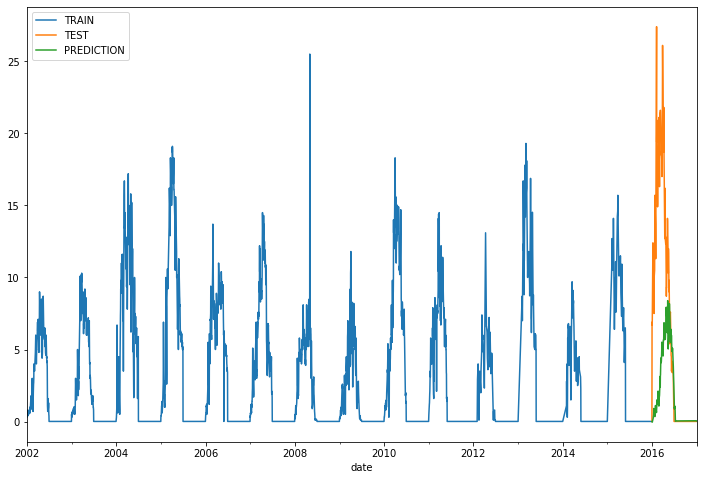

In [35]:
# plot prediction vs. true values
train_df[value_field].plot(legend=True, label='TRAIN')
test_df[value_field].plot(legend=True, label='TEST', figsize=(12,8))
hw_prediction.plot(legend=True, label='PREDICTION');

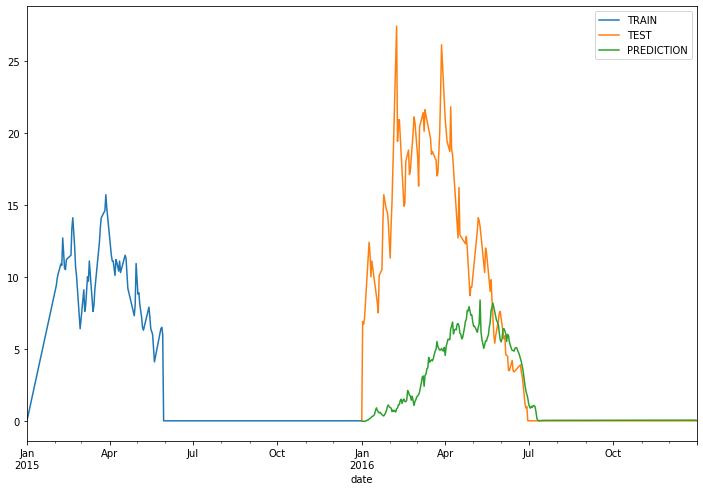

In [36]:
# plot prediction vs. true values on test set (zoomed version)
train_df[value_field].plot(legend=True, label='TRAIN')
test_df[value_field].plot(legend=True, label='TEST', figsize=(12,8))

# when using time series
hw_prediction.plot(legend=True, label='PREDICTION', xlim=[f'{test_year - 1}-01-01', f'{test_year}-12-31']);

# when using index
#hw_prediction.plot(legend=True, label='PREDICTION', xlim=[2000, 2264]);

#### Evaluating Prediction against test set

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [38]:
test_df[value_field].describe()

count   366.00000
mean      6.44730
std       7.84975
min       0.01000
25%       0.01000
50%       0.01000
75%      12.58750
max      27.40000
Name: max, dtype: float64

In [39]:
hw_prediction.describe()

count   366.00000
mean      1.97480
std       2.59631
min      -0.03173
25%       0.05202
50%       0.14486
75%       4.58774
max       8.39298
dtype: float64

1. For using time series: The average of test data value is: 6.45 while the average of prediction value is: 1.97  

2. For using index: The average of test data value is: 14.75 while the average of prediction value is: -0.46

In [40]:
mae = mean_absolute_error(test_df[value_field], hw_prediction)

mae

4.7743783621940175

In [41]:
mse = mean_squared_error(test_df[value_field], hw_prediction)

mse

66.5268167239752

In [42]:
rmse = np.sqrt(mse)

rmse

8.15639728826246

##### Holt-Winters prediction is not that bad  on time series
1. Result on time series: rmse = 2.60 vs. test data STD = 7.85: Error in form of RMSE is about 33% of Test STD => GOOD ENOUGH
2. Result on index: rmse = 16.21 vs. test data STD = 5.14 => SO BAD

#### Forecasting future

In [43]:
# construct a full dataset including train and test datasets
full_df = df[df.index.year <= test_year]
full_df.index

DatetimeIndex(['2002-01-01', '2002-01-02', '2002-01-03', '2002-01-04',
               '2002-01-05', '2002-01-06', '2002-01-07', '2002-01-08',
               '2002-01-09', '2002-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=5479, freq='D')

In [44]:
# Using index instead of time series
#full_df = compact_to_dry_season(full_df)

In [45]:
full_df.head()

,code,min,max
date,,,
2002-01-01,SONDOC,0.10000,0.30000
2002-01-02,SONDOC,0.10000,0.40000
2002-01-03,SONDOC,0.20000,0.40000
2002-01-04,SONDOC,0.20000,0.50000
2002-01-05,SONDOC,0.10000,0.60000


In [46]:
full_df.tail()

,code,min,max
date,,,
2016-12-27,SONDOC,0.01000,0.01000
2016-12-28,SONDOC,0.01000,0.01000
2016-12-29,SONDOC,0.01000,0.01000
2016-12-30,SONDOC,0.01000,0.01000
2016-12-31,SONDOC,0.01000,0.01000


In [47]:
# re-train model on the full dataset of the station
hw_final_model = ExponentialSmoothing(full_df[value_field], 
                                      trend=adjustment, 
                                      seasonal=adjustment, 
                                      seasonal_periods=season_length).fit()

In [48]:
# predict for 2017
hw_next_year_forecast = hw_final_model.forecast(season_length)

hw_next_year_forecast.head()

2017-01-01   0.03699
2017-01-02   0.83786
2017-01-03   0.19734
2017-01-04   0.18096
2017-01-05   0.28018
Freq: D, dtype: float64

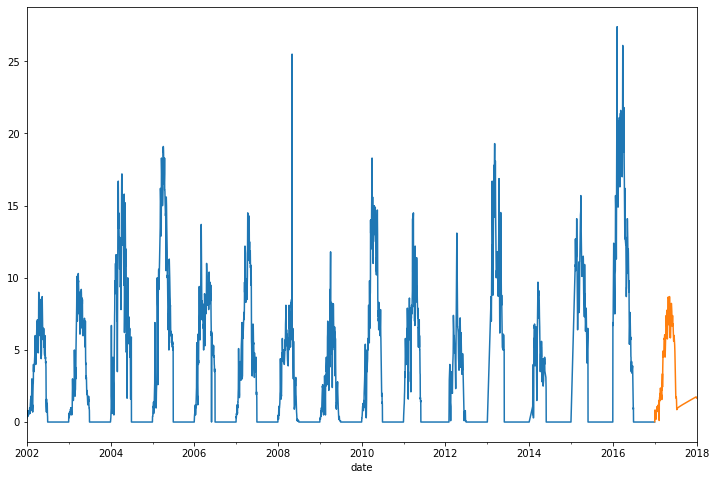

In [49]:
# plot
full_df[value_field].plot(figsize=(12,8))
hw_next_year_forecast.plot();

2. Other simple model goes here

### ARIMA models

1. Using AR component

In [58]:
from statsmodels.tsa.ar_model import AR, ARResults

In [67]:
train_df.head()

,date,code,min,max
0,2002-01-01,SONDOC,0.10000,0.30000
1,2002-01-02,SONDOC,0.10000,0.40000
2,2002-01-03,SONDOC,0.20000,0.40000
3,2002-01-04,SONDOC,0.20000,0.50000
4,2002-01-05,SONDOC,0.10000,0.60000


In [68]:
train_df.tail()

,date,code,min,max
2109,2015-05-27,SONDOC,1.00000,6.40000
2110,2015-05-28,SONDOC,1.60000,6.50000
2111,2015-05-29,SONDOC,3.10000,6.00000
2112,2015-05-30,SONDOC,0.01000,0.01000
2113,2015-05-31,SONDOC,0.01000,0.01000


In [59]:
model = AR(train_df[value_field])

ARfit = model.fit(method='mle', ic='t-stat')

lags = ARfit.k_ar

print(f'Lag: {lags}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 25
Coefficients:
const      0.22007
L1.max     0.88455
L2.max     0.06217
L3.max     0.00191
L4.max    -0.00795
L5.max    -0.01413
L6.max    -0.00902
L7.max     0.00252
L8.max     0.01362
L9.max     0.03489
L10.max   -0.02150
L11.max   -0.01849
L12.max    0.06262
L13.max    0.00517
L14.max    0.01470
L15.max   -0.03221
L16.max    0.04240
L17.max   -0.04144
L18.max    0.00866
L19.max    0.00513
L20.max   -0.03359
L21.max   -0.00773
L22.max    0.03532
L23.max    0.01978
L24.max    0.00539
L25.max   -0.04815
dtype: float64


In [69]:
test_df.head()

,date,code,min,max
2114,2016-01-01,SONDOC,0.01000,0.01000
2115,2016-01-02,SONDOC,2.70000,6.90000
2116,2016-01-03,SONDOC,3.70000,6.70000
2117,2016-01-04,SONDOC,5.30000,7.10000
2118,2016-01-05,SONDOC,5.60000,8.16000


In [70]:
test_df.tail()

,date,code,min,max
2260,2016-05-27,SONDOC,1.30000,6.26667
2261,2016-05-28,SONDOC,1.00000,6.63333
2262,2016-05-29,SONDOC,0.70000,7.00000
2263,2016-05-30,SONDOC,0.90000,7.50000
2264,2016-05-31,SONDOC,1.10000,7.60000


In [60]:
# general formula to calculate time periods for obtaining predictions
start = len(train_df)
end = start + len(test_df) - 1

In [61]:
start

2114

In [62]:
end

2264

In [63]:
ARprediction = ARfit.predict(start=start, end=end).rename(f'AR({lags}) Prediction')

In [65]:
ARprediction.head()

2114   0.16778
2115   0.34245
2116   0.58225
2117   0.94607
2118   1.37856
Name: AR(25) Prediction, dtype: float64

In [66]:
ARprediction.tail()

2260   6.21677
2261   6.21726
2262   6.21771
2263   6.21814
2264   6.21854
Name: AR(25) Prediction, dtype: float64

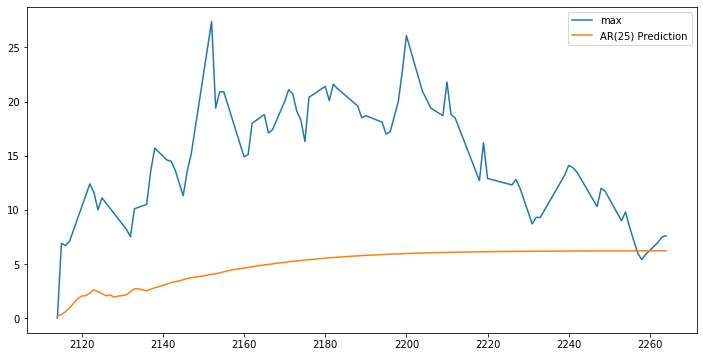

In [64]:
test_df[value_field].plot(legend=True)
ARprediction.plot(legend=True,figsize=(12,6));

AR failed completely. Not surprised!